# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache

## 0.2 Define parameters

In [4]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
train_dataset = Shrec17DatasetCache(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


Better to keep validation and testing set in RAM

In [8]:
val_dataset = Shrec17Dataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

5133it [00:05, 984.13it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [9]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
ids_train = train_dataset.ids
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364 
first id: 000003


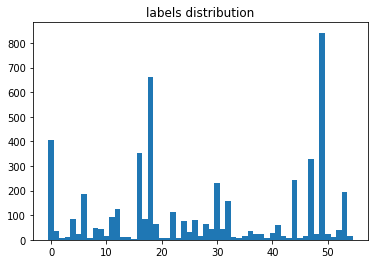

In [10]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

In [11]:
nfeat = x_val.shape[-1]

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [12]:
#training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
#training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [15]:
#EXP_NAME = 'shrec17_best_nsides_reg_{}sides{}'.format(Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = "shrec17_40sim_32sides_0noise_FCN"
EXP_NAME = 'shrec17_Cohen_simple_SGD_max_5K_300epoch_3aug_32sides_CNN'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [16]:
params = hyperparameters.get_params_shrec17(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
model = models.deepsphere(**params)

#sides: [32, 8, 4, 4]
#pixels: [12288, 768, 192, 192]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 38,540,083,200
Learning rate will start at 5.0e-01 and finish at 5.0e-01.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 5 = 3000
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 5 = 50000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [20]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [18]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(training, validation)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 56 = 33600
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 13 = 130000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.35e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.45 (23 / 5133), f1 (weighted): 0.28, loss: 4.20e+00
  CPU time: 247s, wall time: 976s, perf_time: 0.62s
step 2940 / 19602 (epoch 3.00 / 20):
  learning_rate = 3.16e-05, training loss = 3.72e+00
  validation accuracy: 3.37 (173 / 5133), f1 (weighted): 2.86, loss: 3.97e+00
  CPU time: 470s, wall time: 1889s, perf_time: 0.56s
step 4410 / 19602 (epoch 4.50 / 20):
  learning_rate = 1.78e-04, training loss = 3.29e+00
  validation accuracy: 31.09 (1596 / 5133), f1 (weighted): 19.99, loss: 3.17e+00
  CPU time: 686s, wall time: 2769s, perf_time: 0.57s
step 5880 / 19602 (epoch 6.00 / 20):
  learning_rate = 9.98e-04, training loss = 2.18e+00
  validation accuracy: 45.22 (2321 / 5133), f1 (weighted): 33.98, loss: 2.36e+00
  CPU time: 901s, wall time: 3648s, perf_time: 0.56s
step 7350 / 19602 (epoch 7.50 / 20):
  learning_rate = 5.61e-03, training loss = 1.69e+00
  validation accuracy: 57.72 (2963 / 5133), f1 (weighted): 50.28, loss: 1.77e+00
  CPU time: 1118s, wall time: 4

KeyboardInterrupt: 

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [18]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 58,700


In [19]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(train_dataset, validation)

step 490 / 98012 (epoch 0.50 / 100):
  learning_rate = 5.00e-01, training loss = 7.20e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 64.91 (3332 / 5133), f1 (weighted): 61.59, loss: 1.37e+00
  CPU time: 54s, wall time: 84s, perf_time_load: 0.14s, perf_time: 0.10s
step 980 / 98012 (epoch 1.00 / 100):
  learning_rate = 5.00e-01, training loss = 6.50e-01
  validation accuracy: 66.43 (3410 / 5133), f1 (weighted): 63.84, loss: 1.30e+00
  CPU time: 107s, wall time: 168s, perf_time_load: 0.14s, perf_time: 0.10s
step 1470 / 98012 (epoch 1.50 / 100):
  learning_rate = 5.00e-01, training loss = 4.87e-01
  validation accuracy: 70.13 (3600 / 5133), f1 (weighted): 67.48, loss: 1.20e+00
  CPU time: 159s, wall time: 251s, perf_time_load: 0.16s, perf_time: 0.10s
step 1960 / 98012 (epoch 2.00 / 100):
  learning_rate = 5.00e-01, training loss = 4.26e-01
  validation accuracy: 70.52 (3620 / 5133), f1 (weighted): 68.59, loss: 1.13e+00
  CPU time: 210s, wall time: 333s, perf_time_load: 0.15s, perf_time: 0.10s
step 2450 / 98012 (epoch 2.50 / 100):
  learning_rate = 5.00e-01, training loss = 3.87e-01
  validation ac

KeyboardInterrupt: 

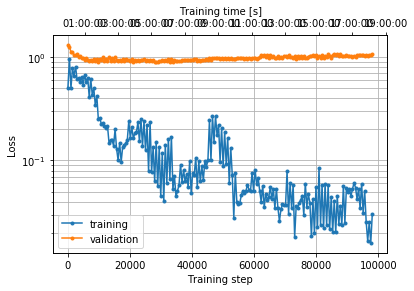

In [51]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [16]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN/model-294037


('accuracy: 96.53 (30277 / 31364), f1 (weighted): 96.54, loss: 1.16e-01\nCPU time: 275s, wall time: 257s',
 96.53424308123964,
 96.54157073077505,
 0.115866209483545)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [ ]:
model.evaluate(x_val, labels_val)

In [ ]:
probabilities = model.probs(x_val, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = repeat.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

In [ ]:
#predictions = predictions.astype(np.int)

In [ ]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_SGD/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_SGD/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [21]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

10265it [00:17, 579.83it/s]


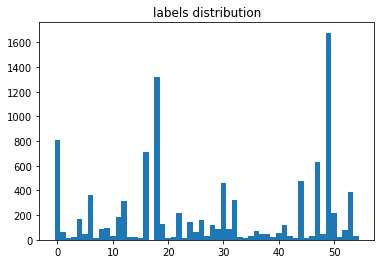

In [22]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [23]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN/model-294037


('accuracy: 74.91 (7690 / 10265), f1 (weighted): 75.08, loss: 1.45e+00\nCPU time: 86s, wall time: 82s',
 74.9147588894301,
 75.08492479251213,
 1.4476807660726705)

In [ ]:
#predictions = model.predict(x_test)

In [24]:
probabilities = model.probs(x_test, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = repeat.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN/model-294037


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [25]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_SGD/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_SGD/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

Why not working?

In [46]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

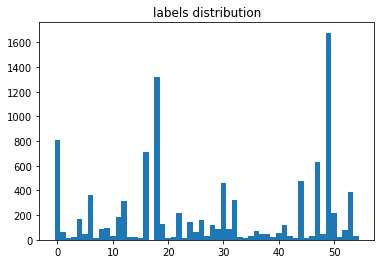

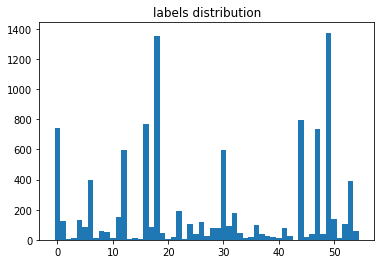

In [47]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)